# **$l^p$-FGSM: A Solution to Catastrophic Overfitting in Fast Adversarial Training**

This notebook provides the official implementation of $l^p$-FGSM (Fast Gradient Sign Method), a method that addresses catastrophic overfitting in fast adversarial training through adaptive norm selection. The implementation accompanies our paper "An $l^p$ Norm Solution to Catastrophic Overfitting in Fast Adversarial Training".

## Implementation Overview

The code demonstrates:
1. The $l^p$-FGSM algorithm for robust training
2. Quantitative analysis of gradient concentration through Participation Ratio
3. Adaptive norm selection based on gradient geometry
4. Empirical evaluation on CIFAR-10, CIFAR-100, and SVHN datasets

## Key Components

- **Base Implementation**: TensorFlow 2.x implementation of WideResNet and PreActResNet architectures
- **Training Framework**: Fast single-step adversarial training with adaptive norm selection
- **Evaluation**: Robustness assessment against PGD-50 and AutoAttack
- **Analysis Tools**: Gradient concentration metrics and visualization utilities

## Requirements

The implementation requires:
```
tensorflow>=2.9.0
numpy>=1.19.2
autoattack  # For evaluation
```
Notebook structure:
```
lpfgsm/
├── 1. Setup and Dependencies
├── 2. Configuration
├── 3. Neural Networks
│   ├── 3.1 WRN
│   └── 3.2 PreActResNet18
├── 4. lp-FGSM
│   ├── 4.1 AdaptiveLpFGSM
│   └── 4.2 Literature Models RS-FGSM N-FGSM GradAlign ZeroGrad
├── 5. Training Framework
│   ├── 5.1 TrainingMonitor
│   ├── 5.2 Dataset Loader
│   └── 5.3 Training Module
└── 6. Run Code
└── 7. Plots

```


## **1. Setup and Dependencies**

In [ ]:
# -*- coding: utf-8 -*-
"""
lp-FGSM: A Novel Solution to Catastrophic Overfitting in Fast Adversarial Training


This notebook implements and demonstrates the lp-FGSM method for robust training
of deep neural networks. The implementation includes model architectures, training
procedures, and evaluation metrics as described in the paper.
"""

# Standard library imports
import os
import math
import random
from typing import Dict, List, Optional, Tuple, Union
import time

# Essential deep learning imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specific TensorFlow components
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.data import AUTOTUNE

# Import AutoAttack & CleverHans for evaluation
try:
    from autoattack import AutoAttack
except ImportError:
    print("AutoAttack not found. Installing...")
    !pip install git+https://github.com/fra31/auto-attack > /dev/null # FOR AutoAttack evaluation

try:
    from cleverhans.tf2.attacks import fast_gradient_method
except ImportError:
    print("CleverHans not found. Installing...")
    !pip install git+https://github.com/cleverhans-lab/cleverhans.git > /dev/null # FOR PGD50 evaluation

# Set random seeds for reproducibility
SEED = 888
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


def get_version_info() -> Dict[str, str]:
    """Get version information for key dependencies."""
    return {
        'tensorflow': tf.__version__,
        'numpy': np.__version__,
        'pandas': pd.__version__
    }
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
# Print environment information
print("Environment Setup:")
for package, version in get_version_info().items():
    print(f"{package}: {version}")

# Enable mixed precision training
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

AutoAttack not found. Installing...
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-wacu0gd2
CleverHans not found. Installing...
  Running command git clone --filter=blob:none --quiet https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-req-build-ohixtfj7
Environment Setup:
tensorflow: 2.18.0
numpy: 1.26.4
pandas: 2.2.2


## **2. Configuration**

In [ ]:
# configuration parameters
cifar10_config = {
    'dataset_name': 'CIFAR10',
    'batch_size': 128,
    'input_dim' : (32, 32, 3),
    'num_classes': 10,
    'epochs': 30,
    'epsilon': 8.0/255.0,
    'alpha': 0.01,
    'weight_decay': 5e-4,
    'lr_max': 0.01,
    'lr_min': 0.0001,
    'arch_params': {
        'N': 4,
        'k': 8,
        'dropout': 0.1
    }
}

cifar100_config = {
    'dataset_name': 'CIFAR100',
    'batch_size': 128,
    'input_dim' : (32, 32, 3),
    'num_classes': 100,
    'epochs': 30,
    'epsilon': 8.0/255.0,
    'alpha': 0.1,
    'weight_decay': 5e-5,
    'lr_max': 0.2,
    'lr_min': 0.01,
    'arch_params': {
        'N': 4,
        'k': 8,
        'dropout': 0.1
    }
}

svhn_config = {
    'dataset_name': 'SVHN',
    'batch_size': 128,
    'input_dim' : (32, 32, 3),
    'num_classes': 10,
    'epochs': 50,
    'epsilon': 8.0/255.0,
    'alpha': 0.01,
    'weight_decay': 5e-4,
    'lr_max': 0.2,
    'lr_min': 0.01,
    'dropout': 0.1
}

## **3. Neural Networks**

### 3.1 WRN

In [ ]:
# WRN (Wide Residual Networks)




from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras import layers
from keras.regularizers import l2
from keras import backend as K

weight_decay = 0.0005
activation = 'relu'

def initial_conv(input):
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)
    ip = (ip-0.5) # [-0.5,0.5], #### MODIFICATION

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)
    #x = Dropout(0.1)(x)
    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay))(x)
    x = layers.Activation('softmax')(x)# important
    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

### 3.2 PreActResNet18

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     Activation, Add, GlobalAveragePooling2D,
                                     Dense, MaxPooling2D, AveragePooling2D, Dropout, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


# PreActResNet18


def preact_res_block(x, filters, activation='relu', kernel_size=(3, 3), stride=1, weight_decay=0.0, dropout_rate=0.0):
    """
    Creates a pre-activation residual block for PreActResNet.

    Args:
        x: Input tensor or layer.
        filters: Number of filters for the convolution layers.
        activation: Activation function to use.
        kernel_size: Size of the convolution kernel.
        stride: Stride size for the convolution.
        weight_decay: L2 regularization factor.
        dropout_rate: Dropout rate.

    Returns:
        A tensor representing the output of the residual block.
    """
    shortcut = x

    # Applying batch normalization, activation, and convolution twice
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filters, kernel_size, strides=stride if _ == 0 else 1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
        if dropout_rate > 0.0:
            x = Dropout(dropout_rate)(x)

    # Adjusting shortcut path for dimensionality matching (if needed)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(shortcut)

    x = Add()([shortcut, x])  # Skip connection (element-wise addition)
    return x

def PreActResNet18(input_shape, num_classes=10, activation='relu', weight_decay=0.0, dropout_rate=0.0):
    """
    Constructs a PreActResNet18 model.

    Args:
        input_shape: Shape of the input data.
        num_classes: Number of classes for the output layer.
        activation: Activation function to use in the blocks.
        weight_decay: L2 regularization factor.
        dropout_rate: Dropout rate.

    Returns:
        A PreActResNet18 model.
    """
    input = Input(input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(2.0 * (input - 0.5))
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Constructing ResNet blocks with specified activation function
    for filters, repetitions, use_strided_conv in zip([64, 128, 256, 512], [2, 2, 2, 2], [False, True, True, True]):
        for i in range(repetitions):
            x = preact_res_block(x, filters, activation, stride=2 if i == 0 and use_strided_conv else 1, weight_decay=weight_decay, dropout_rate=dropout_rate)

    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    x = Dense(num_classes, kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)  # Softmax activation for classification

    return Model(input, x)


## **4. $l^p$-FGSM**

In [ ]:
# @title 4.1 AdaptiveLpFGSM
class AdaptiveLpFGSM(keras.models.Model):
    """Adaptive Lp-FGSM with cosine similarity guidance.

    Implements adaptive norm selection based on gradient concentration metrics
    using entropy gap and participation ratio. The norm is adapted dynamically
    to maintain gradient alignment while preventing catastrophic overfitting.

    Args:
        base_model: Base model to wrap
        eps: Perturbation size (default: 8/255)
        beta: Angle reduction factor (default: 0.8)
            Controls how to reduce angular separation.
            Higher values (closer to 1) maintain closer l2 alignment.
            Lower values (closer to 0) allow more l∞-like behavior.
        vareps: Small constant for numerical stability (default: 1e-12)
    """
    def __init__(self,
                 base_model,
                 eps: float = 8.0/255.0,
                 alpha: float = 0.01,
                 vareps: float = 1e-12,
                 **kwargs):
        super(AdaptiveLpFGSM, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.alpha = alpha
        self.vareps = vareps
        self.cce = tf.keras.losses.CategoricalCrossentropy()

        # Validate parameters
        if not 0.0 < alpha < 1.0:
            raise ValueError("alpha must be in (0,1)")

    @tf.function
    def compute_gradient_statistics(self, gradient):
        """Computes key gradient statistics for norm adaptation.

        Args:
            gradient: Input gradient tensor

        Returns:
            Tuple containing:
            - PR: Participation ratio (effective dimension)
            - H: Shannon entropy
            - Hm: Mean log entropy
            - d: Input dimension
        """
        batch_size = tf.shape(gradient)[0]
        grad_flat = tf.reshape(gradient, [batch_size, -1])

        d = tf.cast(tf.reduce_prod(tf.shape(grad_flat)[1:]), tf.float32)
        # Gradient magnitudes with stability term
        grad_abs = tf.abs(grad_flat) + self.vareps
        grad_norm = tf.reduce_sum(grad_abs, axis=1, keepdims=True)
        pi = grad_abs / grad_norm

        # Participation Ratio computation
        l1_norm = tf.reduce_sum(grad_abs, axis=1)
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_abs), axis=1))
        PR = tf.square(l1_norm / l2_norm)

        # Entropy computations
        H = -tf.reduce_sum(pi * tf.math.log(pi), axis=1)
        Hm = -tf.reduce_mean(tf.math.log(pi), axis=1)

        return PR, H, Hm, d

    @tf.function
    def compute_optimal_q(self, gradient):
        """Computes optimal q based on gradient concentration analysis.

        The computation follows from the paper's theoretical analysis:
        1. Measure gradient concentration via PR and entropy gap
        2. Compute angular separation based on gradient geometry
        3. Apply angle reduction based on beta parameter
        4. Convert to appropriate q value for norm selection
        """
        PR, H, Hm, d = self.compute_gradient_statistics(gradient)

        # Compute entropy gap
        entropy_gap = Hm - H

        # Beta approach
        # Compute angle from participation ratio
        #angle = tf.math.acos(tf.sqrt(PR/d))
        # Apply angle reduction factor (beta)
        #reduced_angle = (1.0-self.beta) * angle
        #tau = tf.math.cos(reduced_angle)
        #q_star = 1.0 + (tau* tf.sqrt(d/PR) - 1.0) / entropy_gap


        q_star = 1.0 + (self.alpha) / entropy_gap

        # Bound q for stability: [1.00098, 2.0] corresponds to p ∈ [2, 1024]
        return tf.clip_by_value(q_star, 1.00098, 2.0)

    @tf.function(jit_compile=True)
    def generate_attack(self, x, y):
        """Generates adversarial examples using adaptive norm."""
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x)
            probs = self(x, training=True)
            loss = self.cce(y, probs)

        gradient = tape.gradient(loss, x)

        # Compute adaptive norm parameters
        q = self.compute_optimal_q(gradient)
        q_expanded = tf.reshape(q, [-1, 1, 1, 1])  # Reshape for broadcasting

        # Generate perturbation
        abs_grad = tf.abs(gradient) + self.vareps
        grad_q_norm = tf.pow(
            tf.reduce_sum(
                tf.pow(abs_grad, q_expanded),
                axis=[1, 2, 3],
                keepdims=True
            ),
            1.0 / q_expanded
        )

        # Scale perturbation by norm
        Upsilon = tf.pow(abs_grad / grad_q_norm, q_expanded - 1.0)
        delta = tf.sign(gradient) * Upsilon

        return x + self.eps * delta, q

    @tf.function(jit_compile=True)
    def train_step(self, data):
        """Executes a single training step with adaptive norm selection."""
        x, y = data

        # Generate adversarial examples
        x_adv, q = self.generate_attack(x, y)

        # Train on adversarial examples
        with tf.GradientTape() as tape:
            probs_adv = self(x_adv, training=True)
            loss = tf.reduce_mean(self.cce(y, probs_adv))

        # Update model parameters
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        # Return metrics including norm statistics
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({
            'q': tf.reduce_mean(q),
            'p': tf.reduce_mean(q / (q - 1.0))
        })

        return metrics

    @tf.function(jit_compile=True)
    def call(self, inputs, training=None):
        return self.base_model(inputs, training=training)

    def get_config(self):
        """Returns the config of the model for serialization."""
        config = super().get_config()
        config.update({
            'eps': self.eps,
            'alpha': self.alpha,
            'vareps': self.vareps
        })
        return config

In [ ]:
# @title 4.2 Literature Models RS-FGSM N-FGSM GradAlign ZeroGrad

class FGSMModel(keras.models.Model):
    def __init__(self, base_model, eps=8.0/255.0, **kwargs):
        super(FGSMModel, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.cce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Add random uniform noise

        x_noise = x

        # Generate adversarial perturbation
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x_noise)
            probs = self(x_noise, training=True)
            loss_init = self.cce(y, probs)

        # Compute gradient and create adversarial example
        dlx = tape.gradient(loss_init, x_noise)
        x_adv = x_noise + self.eps * tf.sign(dlx)

        # Clip to valid range [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

        # Final training step
        with tf.GradientTape() as tape:
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        # Update model parameters
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics
        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        return {metric.name: metric.result() for metric in self.metrics}


class RSFGSMModel(keras.models.Model):
    def __init__(self, base_model, eps=8.0/255.0, **kwargs):
        super(RSFGSMModel, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.cce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Add random uniform noise
        noise = tf.random.uniform(shape=tf.shape(x), minval=-self.eps, maxval=self.eps)
        x_noise = x + noise

        # Generate adversarial perturbation
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x_noise)
            probs = self(x_noise, training=True)
            loss_init = self.cce(y, probs)

        # Compute gradient and create adversarial example
        dlx = tape.gradient(loss_init, x_noise)
        x_adv = x_noise + self.eps * tf.sign(dlx)

        # Clip to valid range [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

        # Final training step
        with tf.GradientTape() as tape:
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        # Update model parameters
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics
        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        return {metric.name: metric.result() for metric in self.metrics}

class GradAlignModel(keras.models.Model):
    def __init__(self, base_model, eps=8.0/255.0, alpha=0.2, **kwargs):
        super(GradAlignModel, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.alpha = alpha
        self.cce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            probs = self(x, training=True)
            loss = self.cce(y, probs)

            # Get first-order gradients
            grad1 = tape.gradient(loss, x)

            # Get perturbed input
            x_pert = x + self.eps * tf.sign(grad1)
            x_pert = tf.clip_by_value(x_pert, 0.0, 1.0)

            # Get second prediction and loss
            probs_pert = self(x_pert, training=True)
            loss_pert = self.cce(y, probs_pert)

            # Get second-order gradients
            grad2 = tape.gradient(loss_pert, x)

            # Compute gradient alignment
            grad1_norm = tf.norm(tf.reshape(grad1, [tf.shape(grad1)[0], -1]), axis=1)
            grad2_norm = tf.norm(tf.reshape(grad2, [tf.shape(grad2)[0], -1]), axis=1)
            grad_align = tf.abs(tf.reduce_sum(
                tf.reshape(grad1, [tf.shape(grad1)[0], -1]) *
                tf.reshape(grad2, [tf.shape(grad2)[0], -1]),
                axis=1
            ) / (grad1_norm * grad2_norm + 1e-7))

            # Create adversarial example with alignment regularization
            gradients = grad1 + self.alpha * tf.expand_dims(grad_align, -1) * grad2
            x_adv = x + self.eps * tf.sign(gradients)
            x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

            # Final forward pass
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        # Update model parameters
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics
        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        return {metric.name: metric.result() for metric in self.metrics}



import tensorflow_probability as tfp

class NFGSMModel(keras.models.Model):
    def __init__(self, base_model, eps=8.0/255.0, k=2.0, **kwargs):
        super(NFGSMModel, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.k = k
        self.cce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Generate amplified random noise
        noise = tf.random.uniform(shape=tf.shape(x), minval=-self.eps, maxval=self.eps)
        x_noise = x + self.k * noise

        # Generate adversarial perturbation
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x_noise)
            probs = self(x_noise, training=True)
            loss_init = self.cce(y, probs)

        # Compute gradient and create adversarial example
        dlx = tape.gradient(loss_init, x_noise)
        x_adv = x_noise + self.eps * tf.sign(dlx)
        # Note: No clipping as per N-FGSM design

        # Final training step
        with tf.GradientTape() as tape:
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        return {metric.name: metric.result() for metric in self.metrics}

class ZeroGradModel(keras.models.Model):
    def __init__(self, base_model, eps=8.0/255.0, quantile=0.95, **kwargs):
        super(ZeroGradModel, self).__init__(**kwargs)
        self.base_model = base_model
        self.eps = eps
        self.quantile = quantile
        self.cce = tf.keras.losses.CategoricalCrossentropy()

    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Generate adversarial perturbation
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x)
            probs = self(x, training=True)
            loss_init = self.cce(y, probs)

        # Compute gradients
        dlx = tape.gradient(loss_init, x)

        # Calculate gradient magnitudes and threshold
        grad_magnitudes = tf.abs(dlx)
        threshold = tfp.stats.percentile(grad_magnitudes, q=self.quantile*100)

        # Zero out small gradients
        mask = tf.cast(grad_magnitudes >= threshold, tf.float32)
        filtered_gradients = dlx * mask

        # Create adversarial example
        x_adv = x + self.eps * tf.sign(filtered_gradients)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

        # Final training step
        with tf.GradientTape() as tape:
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        for metric in self.metrics:
            metric.update_state(y, probs_adv)

        return {metric.name: metric.result() for metric in self.metrics}

## **5. Training Framework**

### 5.1 TrainingMonitor

In [ ]:
class TrainingMonitor(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val, batch_size=128, epsilon=8.0/255.0, alpha=0.001, vareps=1e-12):
        super(TrainingMonitor, self).__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.vareps = vareps
        self.alpha = alpha

        # Initialize metrics storage with correct names
        self.metrics_history = {
            'clean_acc': [],
            'pgd_acc': [],
            'entropy_gap_mean': [],
            'entropy_gap_std': [],
            'p_mean': [],
            'p_std': [],
            'PR_mean': [],
            'PR_std': [],
            'PR1_mean': [],
            'PR1_std': []
        }

    def compute_gradient_metrics(self, x_batch, y_batch):
        """Compute gradient-based metrics."""
        with tf.GradientTape() as tape:
            x_tensor = tf.convert_to_tensor(x_batch)
            tape.watch(x_tensor)
            predictions = self.model(x_tensor, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)

        gradients = tape.gradient(loss, x_tensor)
        gradients = tf.cast(gradients, tf.float32)

        # Compute PR (participation ratio)
        grad_flat = tf.reshape(tf.abs(gradients), [tf.shape(gradients)[0], -1])+self.vareps
        sum_squared = tf.reduce_sum(tf.square(grad_flat), axis=1)
        sum_fourth = tf.reduce_sum(tf.pow(grad_flat, 4), axis=1)
        PR = tf.square(sum_squared) / (sum_fourth )

        # Compute PR1 (L1/L2 norm ratio)
        grad_abs = tf.abs(grad_flat) + self.vareps
        l1_norm = tf.reduce_sum(grad_abs, axis=1)
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_abs), axis=1))
        PR1 = tf.square(l1_norm / l2_norm)

        # Compute entropy metrics
        grad_norm = grad_abs / tf.reduce_sum(grad_abs, axis=1, keepdims=True)
        H = -tf.reduce_sum(grad_norm * tf.math.log(grad_norm + self.vareps), axis=1)
        Hm = -tf.reduce_mean(tf.math.log(grad_norm + self.vareps), axis=1)
        entropy_gap = Hm - H

        # Compute p value
        d = tf.cast(tf.reduce_prod(tf.shape(grad_flat)[1:]), tf.float32)

        # Beta Approach
        #angle = tf.math.acos(tf.sqrt(PR1/d))
        #tau = tf.math.cos(self.beta * angle)
        #q = 1.0 + (tau - 1.0) / (entropy_gap + self.vareps)

        q = 1.0 + (self.alpha) / (entropy_gap )



        q = tf.clip_by_value(q, 1.00098, 2.0)
        p = q / (q - 1.0)

        return {
            'PR': PR.numpy(),
            'PR1': PR1.numpy(),
            'entropy_gap': entropy_gap.numpy(),
            'p': p.numpy()
        }

    def evaluate_pgd(self):
        """Evaluate model against PGD-50 attack."""
        from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

        total_correct = 0
        total_samples = len(self.x_val)

        # Initialize accumulators
        acc_metrics = {
            'PR': [], 'PR1': [], 'entropy_gap': [], 'p': []
        }

        for i in range(0, total_samples, self.batch_size):
            x_batch = self.x_val[i:i + self.batch_size]
            y_batch = self.y_val[i:i + self.batch_size]

            # Generate PGD attack
            x_pgd = projected_gradient_descent(
                self.model,
                x_batch,
                self.epsilon,
                2.0/255.0,
                50,
                np.inf,
                clip_min=0.0,
                clip_max=1.0
            )

            # Compute batch metrics
            batch_metrics = self.compute_gradient_metrics(x_batch, y_batch)
            for key, value in batch_metrics.items():
                acc_metrics[key].extend(value)

            # Evaluate adversarial accuracy
            predictions = np.argmax(self.model.predict(x_pgd), axis=1)
            labels = np.argmax(y_batch, axis=1)
            total_correct += np.sum(predictions == labels)

        # Compute statistics
        results = {}
        results['pgd_acc'] = total_correct / total_samples

        # Compute means and stds for all metrics
        for key in acc_metrics:
            values = np.array(acc_metrics[key])
            results[f'{key}_mean'] = np.mean(values)
            results[f'{key}_std'] = np.std(values)

        return results

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate clean accuracy
        clean_acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)[1]

        # Get PGD accuracy and other metrics
        stats = self.evaluate_pgd()

        # Store metrics
        metrics = {
            'epoch': epoch + 1,
            'clean_acc': clean_acc * 100,
            'pgd_acc': stats['pgd_acc'] * 100,
            'entropy_gap_mean': stats['entropy_gap_mean'],
            'entropy_gap_std': stats['entropy_gap_std'],
            'p_mean': stats['p_mean'],
            'p_std': stats['p_std'],
            'PR_mean': stats['PR_mean'],
            'PR_std': stats['PR_std'],
            'PR1_mean': stats['PR1_mean'],
            'PR1_std': stats['PR1_std']
        }

        # Update history
        for key, value in metrics.items():
            if key in self.metrics_history:
                self.metrics_history[key].append(value)

        # Print progress
        print(f"\nEpoch {epoch + 1} Metrics:")
        print(f"Clean Accuracy: {metrics['clean_acc']:.2f}%")
        print(f"PGD-50 Accuracy: {metrics['pgd_acc']:.2f}%")
        print(f"Entropy Gap: {metrics['entropy_gap_mean']:.2f} ± {metrics['entropy_gap_std']:.2f}")
        print(f"p: {metrics['p_mean']:.2f} ± {metrics['p_std']:.2f}")
        print(f"PR: {metrics['PR_mean']:.2f} ± {metrics['PR_std']:.2f}")
        print(f"PR1: {metrics['PR1_mean']:.2f} ± {metrics['PR1_std']:.2f}")

        # Save to CSV
        pd.DataFrame([metrics]).to_csv(
            'training_metrics.csv',
            mode='a',
            header=not os.path.exists('training_metrics.csv'),
            index=False
        )

### 5.2 Dataset Loader

In [ ]:

import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils
import tensorflow_datasets as tfds

# Set random seed for reproducibility
seed = 88888888
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to load and preprocess SVHN dataset
def load_svhn():
    (svhn_train, svhn_test), ds_info = tfds.load(
        'svhn_cropped', split=['train', 'test'], as_supervised=True, with_info=True, batch_size=-1)

    svhn_train_images, svhn_train_labels = tfds.as_numpy(svhn_train)
    svhn_test_images, svhn_test_labels = tfds.as_numpy(svhn_test)

    # Normalize and preprocess images
    x_train = svhn_train_images.astype("float32") / 255.0
    x_test = svhn_test_images.astype("float32") / 255.0

    x_train = x_train / np.max(x_train, axis=(1, 2, 3), keepdims=True)
    x_test = x_test / np.max(x_test, axis=(1, 2, 3), keepdims=True)

    # Replace any division-by-zero
    x_train[np.isnan(x_train)] = 0
    x_test[np.isnan(x_test)] = 0

    # One-hot encode labels
    num_classes = ds_info.features['label'].num_classes
    y_train = utils.to_categorical(svhn_train_labels, num_classes)
    y_test = utils.to_categorical(svhn_test_labels, num_classes)

    return (x_train, y_train), (x_test, y_test),num_classes

# Function to load and preprocess CIFAR-10 dataset
def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize the data
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # One-hot encode labels
    num_classes = 10
    y_train = utils.to_categorical(y_train, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_test, y_test),num_classes

# Function to load and preprocess CIFAR-100 dataset
def load_cifar100():
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

    # Normalize the data
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # One-hot encode labels
    num_classes = 100
    y_train = utils.to_categorical(y_train, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_test, y_test),num_classes




# Function to apply custom preprocessing and data augmentation based on the dataset
def preprocessing_(dataset_name, x_train, y_train):
    if dataset_name == "SVHN":
        # Custom preprocessing and data augmentation for SVHN
        datagen = ImageDataGenerator(
            rotation_range=8.0,
            zoom_range=[0.95, 1.05],
            height_shift_range=0.10,
            shear_range=0.15
        )
    elif dataset_name == "CIFAR10":
        # Custom preprocessing and data augmentation for CIFAR-10
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=5./32,
            height_shift_range=5./32,
            horizontal_flip=True
        )
    elif dataset_name == "CIFAR100":
        # Custom preprocessing and data augmentation for CIFAR-100
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=5./32,
            height_shift_range=5./32,
            horizontal_flip=True
        )
    else:
        raise ValueError("Unknown dataset")

    # Fit the ImageDataGenerator to the training data
    datagen.fit(x_train,seed=seed, augment=True)

    return datagen

# Function to load and preprocess dataset based on name
def load_and_preprocess_dataset(dataset_name):
    if dataset_name == "SVHN":
        (x_train, y_train), (x_test, y_test), num_classes = load_svhn()
    elif dataset_name == "CIFAR10":
        (x_train, y_train), (x_test, y_test),num_classes = load_cifar10()
    elif dataset_name == "CIFAR100":
        (x_train, y_train), (x_test, y_test),num_classes = load_cifar100()
    else:
        raise ValueError("Unknown dataset")

    # Preprocessing and data augmentation
    datagen = preprocessing_(dataset_name, x_train, y_train)

    return datagen, (x_train, y_train), (x_test, y_test),num_classes

### 5.3 Training Module


In [ ]:
def create_cyclic_lr_schedule(epochs, lr_max=0.2, lr_min=0.01):
    """Create cyclic learning rate schedule."""
    class CyclicLR(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, lr_max, lr_min, nb_epochs):
            self.lr_max = lr_max
            self.lr_min = lr_min
            self.nb_epochs = nb_epochs

        def __call__(self, step):
            epoch = tf.cast(step // self.nb_epochs, dtype=tf.float32)
            cycle = tf.constant(np.pi, dtype=tf.float32) * epoch / tf.cast(self.nb_epochs, dtype=tf.float32)
            return self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + tf.math.cos(cycle))

    return CyclicLR(lr_max, lr_min, epochs)

def create_callbacks(x_test, y_test, exp_name, alpha, save_dir='experiments'):
    """Create training callbacks with experiment-specific paths."""
    # Create experiment directory
    exp_dir = os.path.join(save_dir, exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(exp_dir, 'model_{epoch:02d}.weights.h5'),
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Training monitor
    monitor = TrainingMonitor(
        x_test[:1024], y_test[:1024],
        batch_size=128,
        epsilon=8.0/255.0,
        alpha=alpha
    )

    return [checkpoint, monitor]

def train_model(dataset_name, config=None, exp_name=None):
    """Main training function with dataset flexibility.

    Args:
        dataset_name: Name of dataset ("SVHN", "CIFAR10", or "CIFAR100")
        config: Optional dictionary with training parameters
        exp_name: Name for the experiment (for saving results)
    """
    if config is None:
        config = {
            'dataset_name': dataset_name,
            'batch_size': 1024,
            'input_dim' : (32, 32, 3),
            'num_classes': 10,
            'epochs': 30,
            'epsilon': 8.0/255.0,
            'alpha': 0.001,
            'weight_decay': 5e-4,
            'lr_max': 0.2,
            'lr_min': 0.01,
            'arch_params': {
                'N': 4,
                'k': 8,
                'dropout': 0.1
            }
        }

    if exp_name is None:
        exp_name = f"{dataset_name}_lpfgsm_{int(time.time())}"

    # Load and preprocess data
    datagen, (x_train, y_train), (x_test, y_test), num_classes = load_and_preprocess_dataset(dataset_name)

    # Model selection based on dataset
    if dataset_name == 'SVHN':
        model = PreActResNet18(input_shape=config['input_dim'], num_classes=config['num_classes'], weight_decay=config['weight_decay'], dropout_rate=config['dropout'], activation='relu')
    elif dataset_name in ['CIFAR10', 'CIFAR100']:
            base_model = create_wide_residual_network(
            input_dim=config['input_dim'],  # Standard input shape for these datasets
            nb_classes=config['num_classes'],
            N=config['arch_params']['N'],
            k=config['arch_params']['k'],
            dropout=config['arch_params']['dropout'])
    else:
        raise ValueError("Unknown dataset")




    model = AdaptiveLpFGSM(
        base_model=base_model,
        eps=config['epsilon'],
        alpha=config['alpha']
    )

    # Setup optimizer with cyclic learning rate
    lr_schedule = create_cyclic_lr_schedule(
        config['epochs'],
        config['lr_max'],
        config['lr_min']
    )


    optimizer = AdamW(
        learning_rate=0.0001,
        weight_decay=config['weight_decay']
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Setup callbacks
    callbacks = create_callbacks(x_test, y_test, alpha=config['alpha'], exp_name=exp_name)

    # Train model
    history = model.fit(
        datagen.flow(
            x_train, y_train,
            batch_size=config['batch_size']
        ),
        epochs=config['epochs'],
        callbacks=callbacks,
        validation_data=(x_test, y_test),
        verbose=1
    )

    # Save final evaluation results
    evaluate_model(model, x_test, y_test, config['epsilon'])

    # Save configuration
    #with open(os.path.join('experiments', exp_name, 'config.json'), 'w') as f:
    #    json.dump(config, f, indent=4)

    return model, history

def evaluate_model(model, x_test, y_test, epsilon=8.0/255.0, batch_size=128):
    """Evaluate model robustness with batch processing.

    Args:
        model: Model to evaluate
        x_test: Test images
        y_test: Test labels
        epsilon: Perturbation size
        batch_size: Batch size for memory efficiency
    """


    results = {}
    total_samples = len(x_test)
    num_batches = int(np.ceil(total_samples / batch_size))

    # Clean accuracy in batches
    clean_correct = 0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)

        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        predictions = model(x_batch, training=False)
        clean_correct += tf.reduce_sum(
            tf.cast(
                tf.equal(
                    tf.argmax(predictions, axis=1),
                    tf.argmax(y_batch, axis=1)
                ),
                tf.float32
            )
        )

    results['clean_acc'] = (clean_correct / total_samples).numpy()

    # PGD accuracy in batches
    pgd_correct = 0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)

        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        # Generate PGD attack for batch
        x_pgd = projected_gradient_descent(
            model,
            x_batch,
            epsilon,
            2.0/255.0,
            50,
            np.inf,
            clip_min=0.0,
            clip_max=1.0
        )

        # Evaluate on adversarial examples
        predictions = model(x_pgd, training=False)
        pgd_correct += tf.reduce_sum(
            tf.cast(
                tf.equal(
                    tf.argmax(predictions, axis=1),
                    tf.argmax(y_batch, axis=1)
                ),
                tf.float32
            )
        )

    results['pgd_acc'] = (pgd_correct / total_samples).numpy()

    # Print results
    print("\nFinal Evaluation:")
    print(f"Clean Accuracy: {results['clean_acc']*100:.2f}%")
    print(f"PGD-50 Accuracy: {results['pgd_acc']*100:.2f}%")

    return results





## **6. Run Code**

In [ ]:
# Example usage:
if __name__ == "__main__":

    dataset_name="CIFAR10" # choose from SVHN, CIFAR10, CIFAR100
    if dataset_name == "SVHN":
        config = svhn_config
    elif dataset_name == "CIFAR10":
        config = cifar10_config
    elif dataset_name == "CIFAR100":
        config = cifar100_config


    # Example usage
    model, history = train_model(
        dataset_name=dataset_name,
        config=config,
        exp_name="demo"
    )

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step
Wide Residual Network-28-8 created.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Epoch 1 Metrics:
Clean Accuracy: 41.80%
PGD-50 Accuracy: 37.60%
Entropy Gap: 1.42 ± 0.29
p: 142.90 ± 29.08
PR: 256.83 ± 125.81
PR1: 1078.25 ± 234.82
391/391 ━━━━━━━━━━━━━━━━━━━━ 136s 253ms/step - accuracy: 0.1957 - loss: 0.1141 - p: 133.2929 - q: 1.0081 - val_accuracy: 0.4087 - val_loss: 9.9477
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Epoch 2 Metrics:
Clean Accuracy: 49.32%
PGD-50 Accuracy: 42.09%
Entropy Gap: 1.42 ±

## **7. Plots**

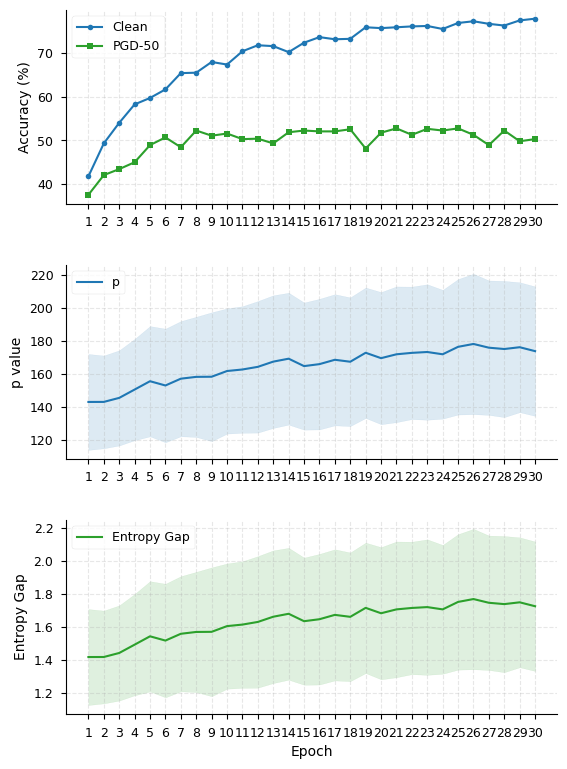

In [ ]:
def plot_training_metrics(df):
    """Create publication-quality plots for ICML with adjusted spacing for 10 epochs."""
    # Set style
    plt.style.use('seaborn-v0_8-paper')

    # Setup figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
    fig.tight_layout(pad=2.5)

    # Color scheme
    colors = ['#1f77b4', '#2ca02c']  # Professional blue and green

    # Generate x values
    epochs = df['epoch'].values

    # 1. Clean and Adversarial Accuracy
    line1 = ax1.plot(epochs, df['clean_acc'], color=colors[0],
                    marker='o', markersize=4, linewidth=1.5,
                    label='Clean')[0]
    line2 = ax1.plot(epochs, df['pgd_acc'], color=colors[1],
                    marker='s', markersize=4, linewidth=1.5,
                    label='PGD-50')[0]
    ax1.set_ylabel('Accuracy (%)', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend(handles=[line1, line2], loc='best', frameon=True, fontsize=9)

    # 2. p value with std
    ax2.plot(epochs, df['p_mean'], color=colors[0], linewidth=1.5, label='p')
    ax2.fill_between(epochs,
                    df['p_mean'] - df['p_std'],
                    df['p_mean'] + df['p_std'],
                    color=colors[0], alpha=0.15)
    ax2.set_ylabel('p value', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(loc='best', frameon=True, fontsize=9)

    # 3. Entropy gap with std
    ax3.plot(epochs, df['entropy_gap_mean'], color=colors[1],
            linewidth=1.5, label='Entropy Gap')
    ax3.fill_between(epochs,
                    df['entropy_gap_mean'] - df['entropy_gap_std'],
                    df['entropy_gap_mean'] + df['entropy_gap_std'],
                    color=colors[1], alpha=0.15)
    ax3.set_ylabel('Entropy Gap', fontsize=10)
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.3)
    ax3.legend(loc='best', frameon=True, fontsize=9)

    # General styling for all subplots
    for ax in [ax1, ax2, ax3]:
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Set tick parameters
        ax.tick_params(axis='both', which='major', labelsize=9)

        # Set x-axis ticks
        ax.set_xticks(epochs)

        # Add minor gridlines
        ax.grid(True, which='major', linestyle='--', alpha=0.3)

    plt.show()

# Read and plot the data
df = pd.read_csv('training_metrics.csv')
plot_training_metrics(df)